In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

## Dataset 

In [2]:
data_dir = 'C:/Users/Antonin_Joly/Desktop'
df = pd.read_csv(os.path.join(data_dir,'Eartquakes-1990-2023.csv')).dropna(axis=0)
cnt = Counter(pd.to_datetime(df['date']).dt.strftime('%Y-%m'))
cnt = dict(sorted(cnt.items(), reverse=False))

data = pd.DataFrame(list(cnt.values()), columns=['occurence'])
data.index = pd.to_datetime(list(cnt.keys()))
data["rolling_avg"] = data["occurence"].rolling(window=12).mean()
data["rolling_std"] = data["occurence"].rolling(window=12).std()

df, df_test = data.iloc[:int(0.85*data.shape[0]), :], data.iloc[int(0.85*data.shape[0])-1:, :]

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 398 entries, 1990-01-01 to 2023-07-01
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   occurence    398 non-null    int64  
 1   rolling_avg  387 non-null    float64
 2   rolling_std  387 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 12.4 KB
None


,occurence,rolling_avg,rolling_std
1990-01-01,4373,NaN,NaN
1990-02-01,4840,NaN,NaN
1990-03-01,6165,NaN,NaN
1990-04-01,5141,NaN,NaN
1990-05-01,4414,NaN,NaN


## DATA BEHAVIOR VISUALIZATION

In [3]:
ssn = seasonal_decompose(data['occurence'], model="additive", period=12)

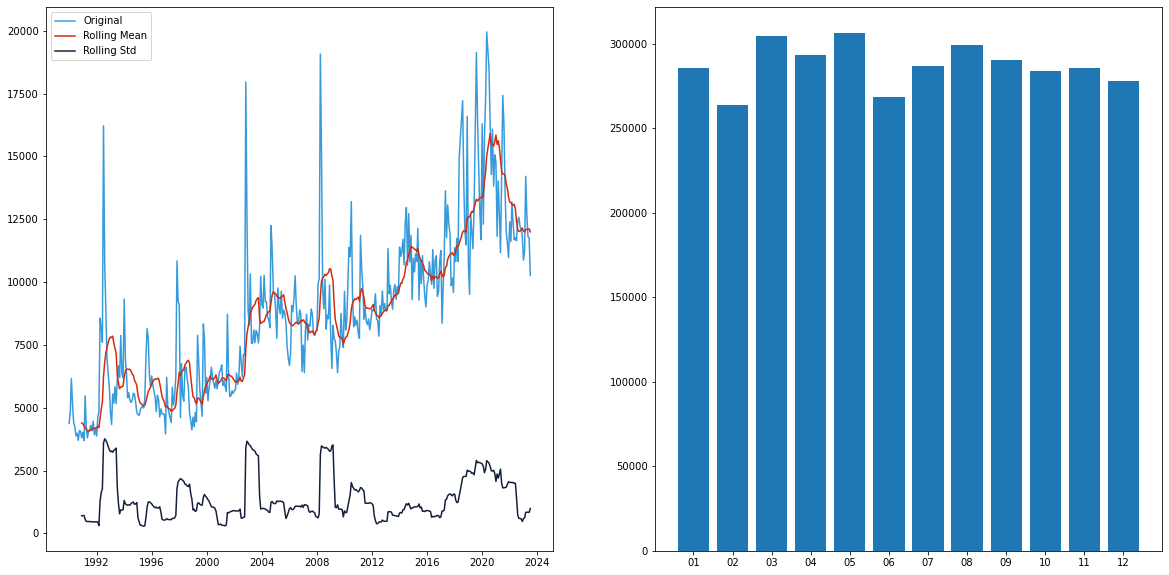

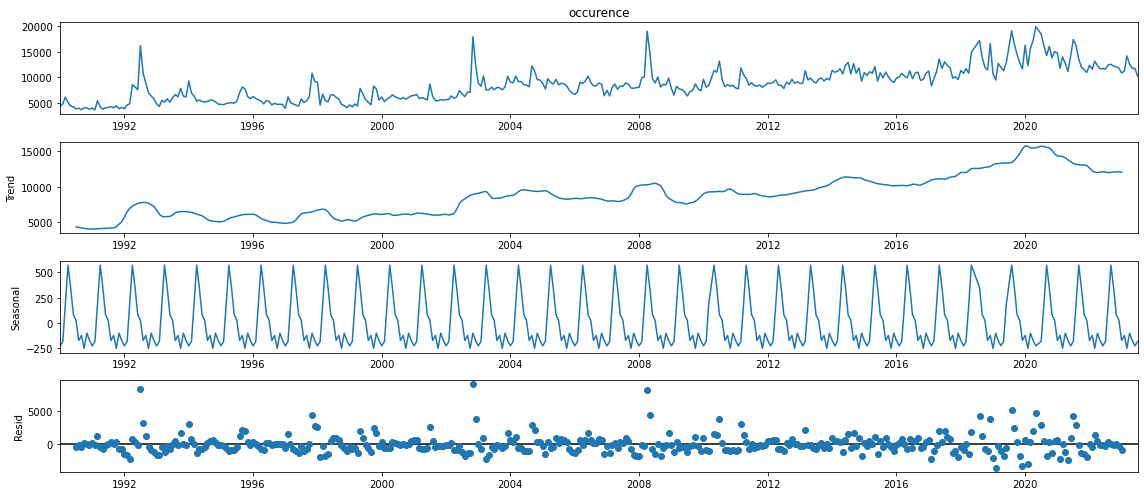

In [4]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(data["occurence"], color='#379BDB', label='Original')
plt.plot(data["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(data["rolling_std"], color='#142039', label='Rolling Std')
plt.legend()
plt.subplot(1,2,2)
month = [str('%02d'%(i)) for i in range(1,13)]
cnt = [np.sum([r['occurence'] for idx, r in data.iterrows() if str(idx).split('-')[1]==d]) for d in month]# df['Sale'].values
plt.bar(month, cnt)

plt.rc("figure", figsize=(16, 7))
plt.rc("font", size=10)
fig = ssn.plot()
plt.show()

# Data stationarity test

In [5]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(data['occurence'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -2.193094
p-value                          0.208762
#Lags Used                       7.000000
Number of Observations Used    390.000000
Critical Value (1%)             -3.447229
Critical Value (5%)             -2.868980
Critical Value (10%)            -2.570733
dtype: float64


# Auto ARIMA

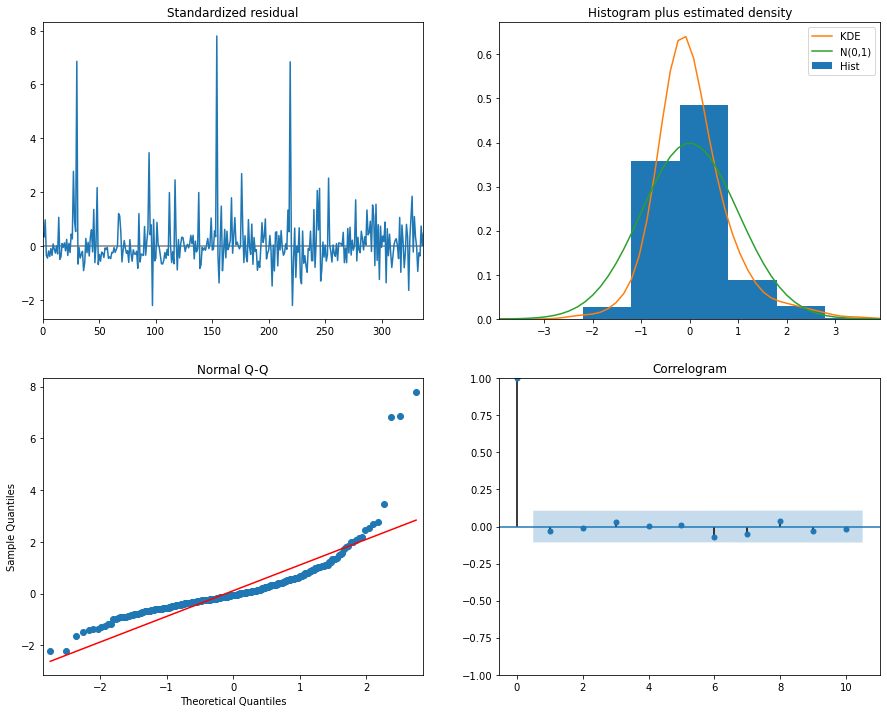

In [6]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['occurence'], 
                            start_p=1, 
                            start_q=1,
                            test='adf', # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,# let model determine 'd'
                            seasonal=False, # No Seasonality for standard ARIMA
                            trace=False, #logs 
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True)

ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [7]:
def forecast(ARIMA_model, periods=24):
    fitted, confint = ARIMA_model.predict(n_periods=periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = periods, freq='MS')
    
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    
    return fitted_series, lower_series, upper_series

def sarimax_forecast(SARIMAX_model, periods=24):
    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=periods, return_conf_int=True, exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = periods, freq='MS')
    
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    
    return fitted_series, lower_series, upper_series

C:\Users\Antonin_Joly\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


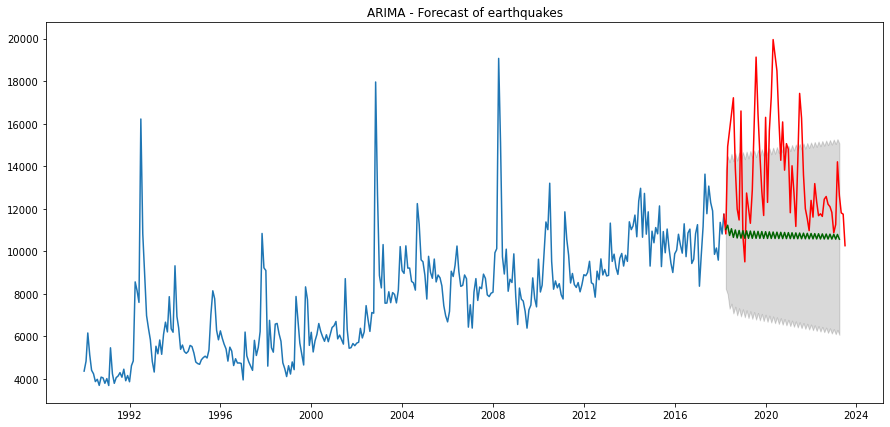

In [8]:
fitted_series, lower_series, upper_series = forecast(ARIMA_model, periods=df_test.shape[0])

plt.figure(figsize=(15,7))
plt.plot(df["occurence"], color='#1f76b4')
plt.plot(df_test["occurence"], color='red')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title("ARIMA - Forecast of earthquakes")
plt.show()

# Auto SARIMA

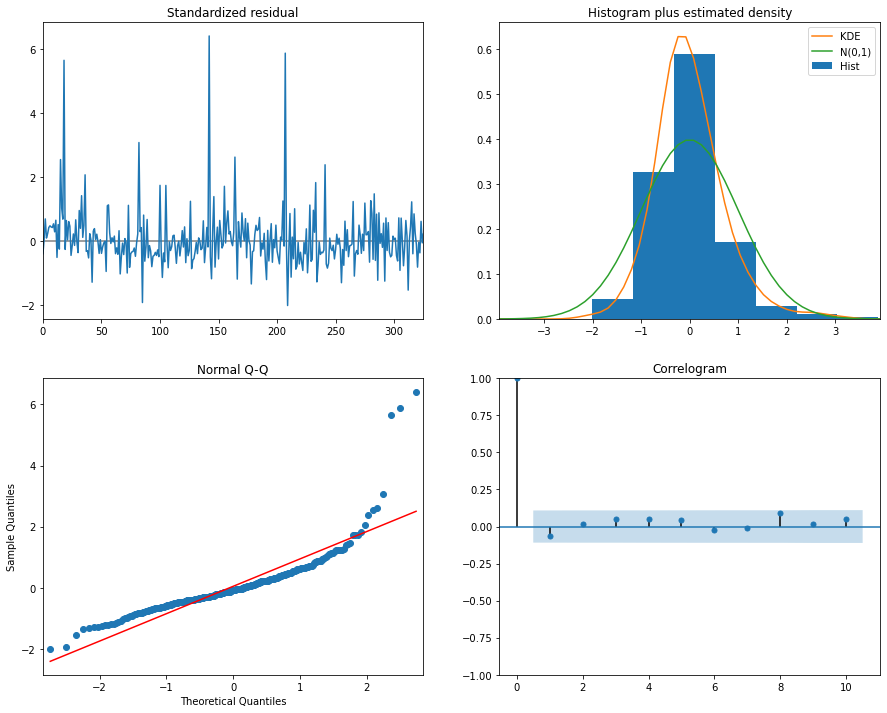

In [9]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["occurence"], start_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3, 
                             m=12, #12 is the frequncy of the cycle
                             start_P=0, 
                             seasonal=True, #set to seasonal
                             d=None, 
                             D=1, #order of the seasonal differencing
                             trace=False,
                             error_action='ignore',
                             suppress_warnings=True, 
                             stepwise=True)

SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

C:\Users\Antonin_Joly\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


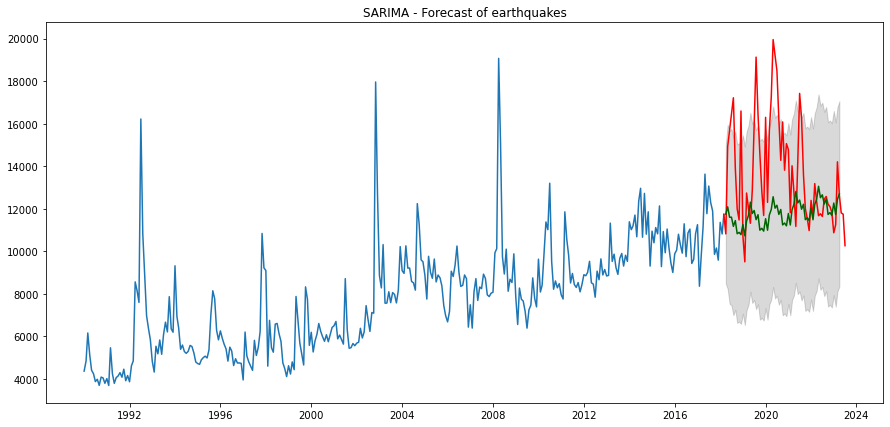

In [10]:
fitted_series, lower_series, upper_series = forecast(SARIMA_model, periods=df_test.shape[0])

plt.figure(figsize=(15,7))
plt.plot(df["occurence"], color='#1f76b4')
plt.plot(df_test["occurence"], color='red')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title("SARIMA - Forecast of earthquakes")
plt.show()

# Auto SARIMAX

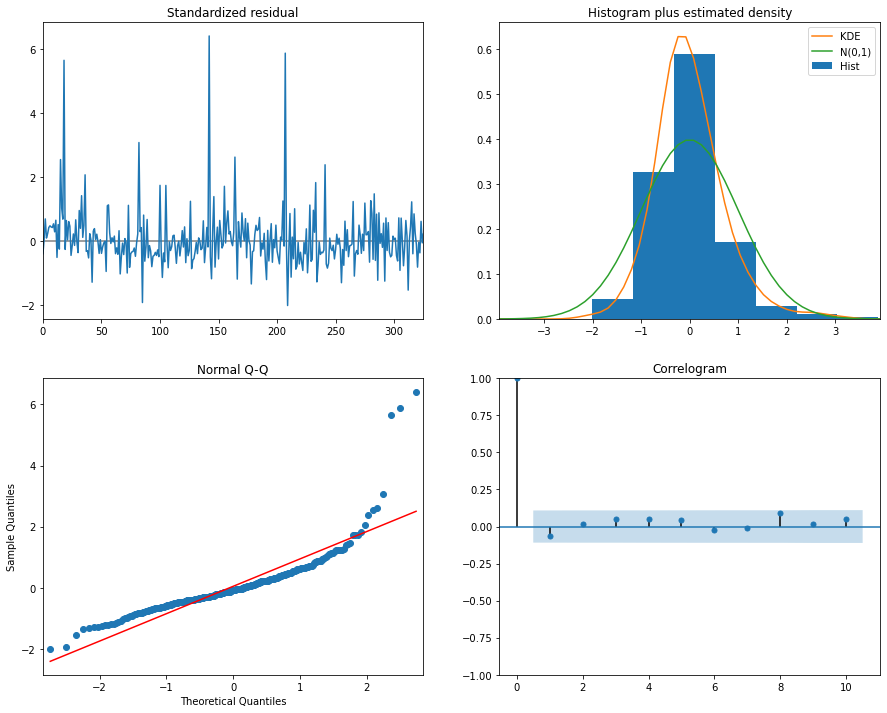

In [11]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['occurence']],
                              exogenous=df[['month_index']],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3, m=12,
                              start_P=0, seasonal=True,
                              d=None, D=1, 
                              trace=False,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

C:\Users\Antonin_Joly\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


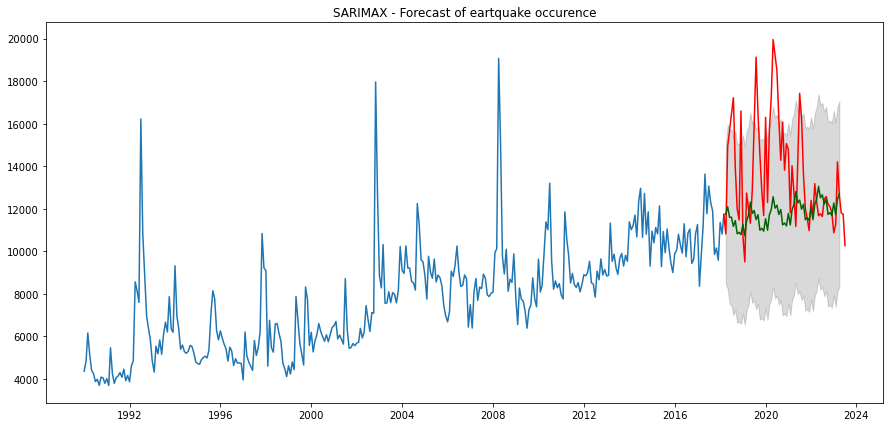

In [12]:
fitted_series, lower_series, upper_series = sarimax_forecast(SARIMAX_model, periods=df_test.shape[0])

plt.figure(figsize=(15,7))
plt.plot(df["occurence"], color='#1f76b4')
plt.plot(df_test["occurence"], color='red')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("SARIMAX - Forecast of eartquake occurence")
plt.show()

In [13]:
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    print(data.shape)
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    print(sequences.shape)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

In [14]:
dropout = 0.2
seq_len = 60
window_size = seq_len - 1
batch_size = 16

In [15]:
scaler = MinMaxScaler()
scaled_occurence = scaler.fit_transform(df['occurence'].values.reshape(-1, 1))

X_train, y_train, X, y = get_train_test_sets(scaled_occurence, seq_len, train_frac=0.8)
X_val, X_test = X[:int(X.shape[0]/2),:,:], X[int(X.shape[0]/2):,:,:]
y_val, y_test = y[:int(X.shape[0]/2),:], y[int(X.shape[0]/2):,:]

(338, 1)
(279, 60, 1)
(209, 59, 1) (209, 1) (70, 59, 1) (70, 1)
(61, 1)
(2, 60, 1)


In [16]:
callbacks_list = [EarlyStopping(patience=20),
                  ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.2,
                                    patience=5,
                                    min_lr=0.001)]
metrics = [MeanSquaredError(), MeanAbsoluteError()]

In [18]:
# build a 3-layer LSTM RNN
model = keras.Sequential()
model.add(LSTM(window_size, return_sequences=True, input_shape=(window_size, X_train.shape[-1])))
model.add(Dropout(rate=dropout))# Bidirectional allows for training of sequence data forwards and backwards
model.add(Bidirectional(LSTM((window_size * 2), return_sequences=True))) 
model.add(Dropout(rate=dropout))
model.add(Bidirectional(LSTM(window_size, return_sequences=False))) 
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = metrics)

In [19]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=batch_size,
                    shuffle=False,
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val),
                    verbose=0)

In [20]:
results = model.evaluate(X_test, y_test, verbose=2)

1/1 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1898 - 35ms/epoch - 35ms/step


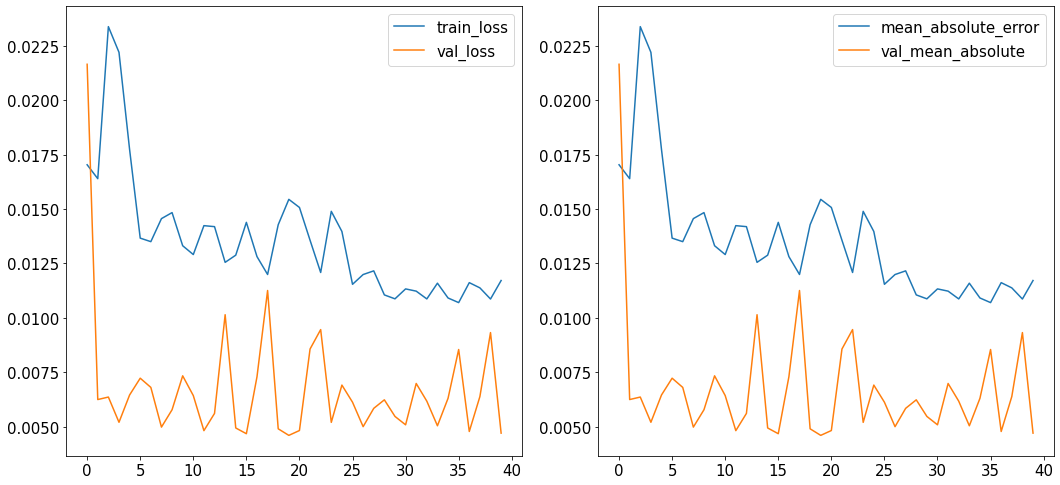

In [21]:
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 15})

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mean_squared_error'], label='mean_absolute_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_absolute')
plt.legend()

plt.tight_layout()

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='#1f76b4', label='Historical occurence')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual occurence')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted occurence')

plt.legend()
plt.show()

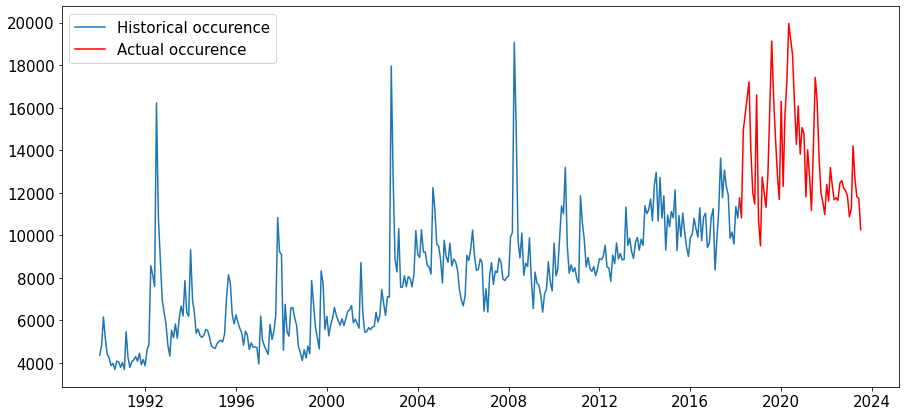

In [22]:
y_pred = scaler.inverse_transform(model.predict(X_test))

plt.figure(figsize=(15,7))
plt.plot(df["occurence"], color='#1f76b4', label='Historical occurence')
plt.plot(df_test["occurence"], color='red', label='Actual occurence')
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='darkgreen', label='Predicted occurence')

plt.legend()
plt.show()

In [23]:
y_pred

array([[13051.948],
       [12928.129]], dtype=float32)